In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 0
subj_base = 'sub-789/pipr-90s-binoc-sub-789_ses-01_dat-20230728' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

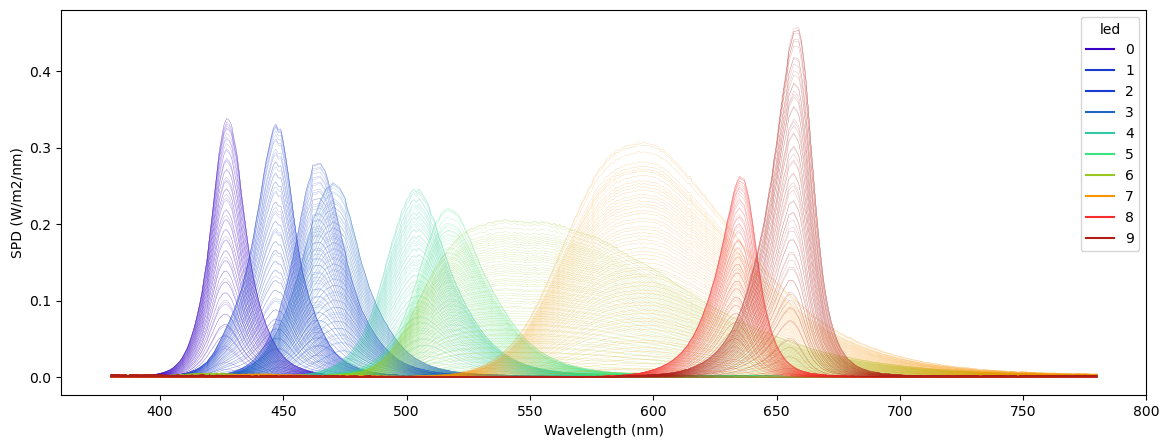

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


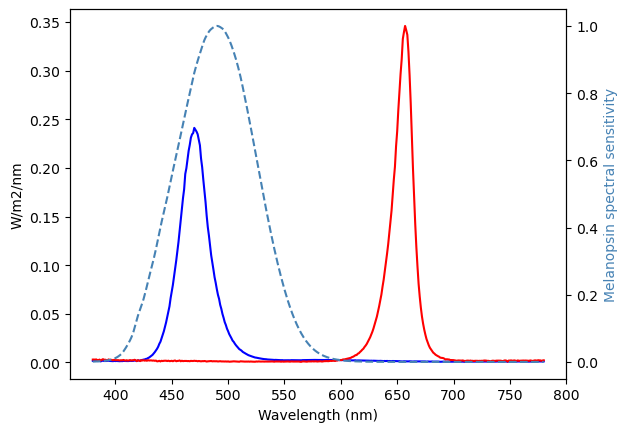

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [10]:
d.turn_off()

<Response [200]>

In [11]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 789
> Grabbing 570 seconds of pupil.1.3d> Grabbing 570 seconds of pupil.0.3d

> Waiting for a light to stamp...
> Light stamped on frame.world at 605242.2388820001
> Waiting for a light to stamp...
> Light stamped on frame.world at 605333.846304
> Waiting for a light to stamp...
> Light stamped on frame.world at 605425.393135
> Waiting for a light to stamp...
> Light stamped on frame.world at 605516.871075
> PupilGrabber done grabbing 570 seconds of pupil.1.3d
> PupilGrabber done grabbing 570 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 605608.295351
> Waiting for a light to stamp...
> Light stamped on frame.world at 605699.8323540001
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for

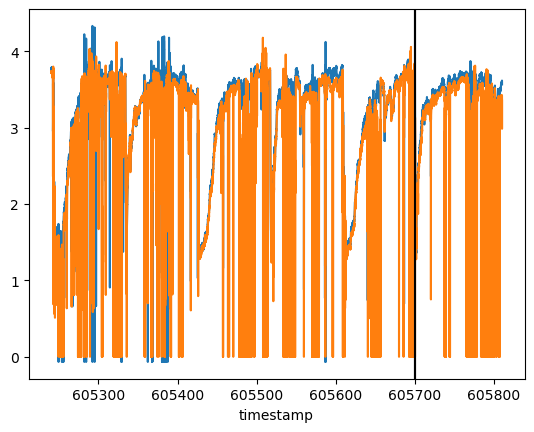

In [12]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [13]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
605240.157789,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5895513959936737, 0.35830359317116944]",57.699234,0.992695,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.6564233238708521, 1.961355547119...",3.764943,"{'center': [113.19386803078535, 123.2057101111...","[113.19386803078535, 123.20571011113547]",1.0,1.524538,-2.294460
605240.182815,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5896360775579659, 0.3582301510082794]",57.553898,1.000000,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.6576959798122086, 1.962284714954...",3.755242,"{'center': [113.21012689112945, 123.2198110064...","[113.21012689112945, 123.21981100641035]",1.0,1.524449,-2.294300
605240.203856,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5894384005923273, 0.35774301049172463]",57.729042,1.000000,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.6550675087907223, 1.968915533985...",3.766915,"{'center': [113.17217291372684, 123.3133419855...","[113.17217291372684, 123.31334198558888]",1.0,1.523810,-2.294664
605240.221760,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5894364738282535, 0.3581628288627813]",57.679713,1.000000,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.655077905532309, 1.9633403394698...",3.763797,"{'center': [113.17180297502466, 123.2327368583...","[113.17180297502466, 123.232736858346]",1.0,1.524347,-2.294641
605240.244593,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5894469885339494, 0.3577265714444732]",57.686303,1.000000,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.6552436165267084, 1.969135341017...",3.764089,"{'center': [113.17382179851828, 123.3164982826...","[113.17382179851828, 123.31649828266114]",1.0,1.523789,-2.294642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605810.108374,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.6029632507832392, 0.33447777828872693]",55.264357,0.920232,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.8256009269589875, 2.265457584770...",3.578846,"{'center': [115.76894415038193, 127.7802665685...","[115.76894415038193, 127.78026656856443]",1.0,1.495220,-2.274432
605810.122003,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.6029979667751612, 0.3348136692676542]",55.230130,0.964776,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.826014890330737, 2.2609664814358...",3.576659,"{'center': [115.77560962083095, 127.7157755006...","[115.77560962083095, 127.71577550061039]",1.0,1.495654,-2.274352
605810.143465,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.603584752430807, 0.33466732930457954]",55.160625,0.992020,"{'center': [8.530166134205565, 1.4807972871185...","{'center': [178.87159923048404, 110.3248677108...","{'center': [1.8332061212103543, 2.262320946527...",3.571235,"{'center': [115.88827246671495, 127.7438727735...","[115.88827246671495, 127.74387277352072]",1.0,1.495523,-2.273450


In [14]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
605240.157428,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3330446508926409, 0.7627210451013872]",70.138198,0.941010,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.579014334977277, -2.93279563708...",3.734824,"{'center': [63.94457297138705, 45.557559340533...","[63.94457297138705, 45.557559340533665]",1.0,1.656932,-2.214461
605240.182773,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.33320410095793873, 0.7627969913205771]",70.063306,0.944968,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.5771128339358738, -2.9334375886...",3.730621,"{'center': [63.975187383924236, 45.54297766644...","[63.975187383924236, 45.54297766644919]",1.0,1.656994,-2.214235
605240.201526,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3338009908543013, 0.7627545983038324]",70.014287,0.835165,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.5703628774002318, -2.9322390784...",3.727216,"{'center': [64.08979024402585, 45.551117125664...","[64.08979024402585, 45.551117125664184]",1.0,1.656878,-2.213413
605240.222049,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3332867754588121, 0.7632527051612693]",70.026990,0.924637,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.5761240320761267, -2.9383221945...",3.728543,"{'center': [63.991060888091916, 45.45548060903...","[63.991060888091916, 45.45548060903629]",1.0,1.657466,-2.214146
605240.243084,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3332455782053002, 0.7636229361757955]",69.942310,0.911315,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.5764471516403882, -2.9424331075...",3.724068,"{'center': [63.98315101541764, 45.384396254247...","[63.98315101541764, 45.38439625424727]",1.0,1.657863,-2.214211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605810.101355,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.35665002069516577, 0.7974983542751729]",64.707897,0.810419,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.3088522569095034, -3.2834007062...",3.416461,"{'center': [68.47680397347183, 38.880315979166...","[68.47680397347183, 38.88031597916681]",1.0,1.690851,-2.184691
605810.114961,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.35638807515309584, 0.7968977978467133]",64.353649,0.930162,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.311266735700178, -3.27721631373...",3.398191,"{'center': [68.4265104293944, 38.9956228134310...","[68.4265104293944, 38.99562281343104]",1.0,1.690251,-2.184927
605810.138174,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.357769342059544, 0.7955990123721783]",63.988642,0.769984,"{'center': [4.6346035709914695, -2.03875517349...","{'center': [146.26122619287207, 73.84324775956...","{'center': [-1.2956109536613445, -3.2612697031...",3.377457,"{'center': [68.69171367543245, 39.244989624541...","[68.69171367543245, 39.24498962454176]",1.0,1.688706,-2.182942


In [15]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [16]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

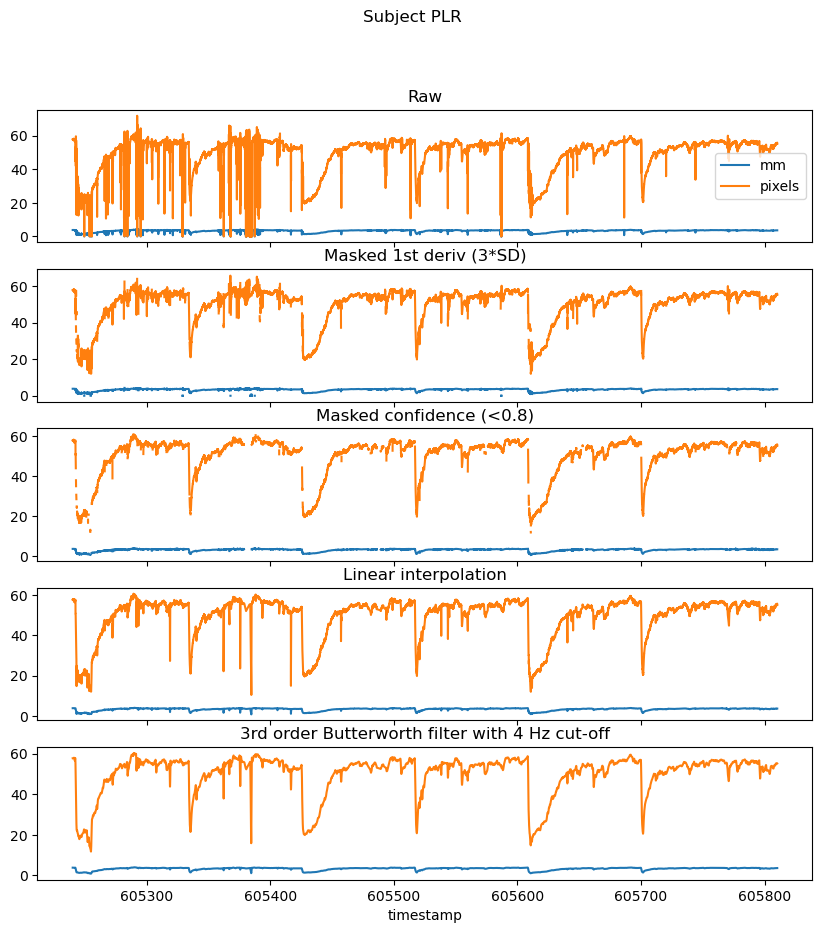

In [17]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [18]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

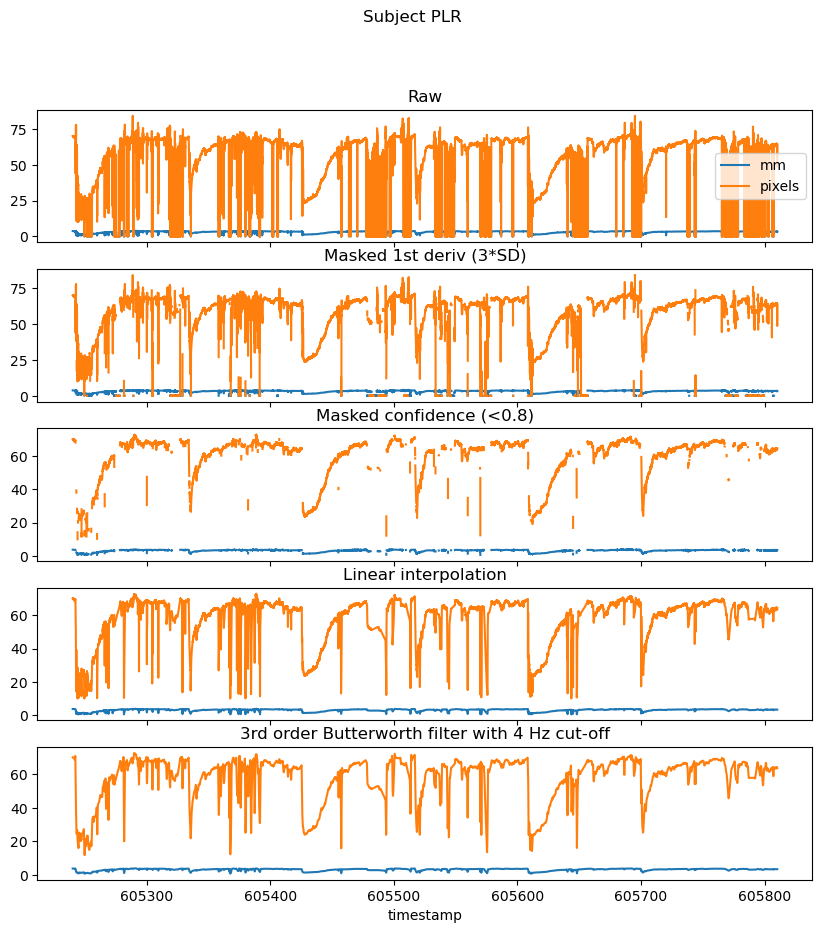

In [19]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [20]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

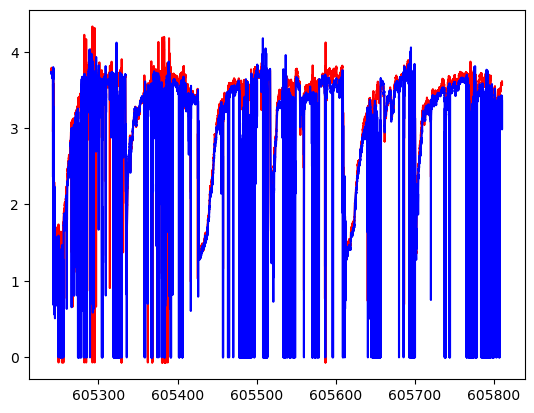

In [23]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 605242.2388820001
> Waiting for a light to stamp...
> Light stamped on frame.world at 605333.846304
> Waiting for a light to stamp...
> Light stamped on frame.world at 605425.393135
> Waiting for a light to stamp...
> Light stamped on frame.world at 605516.871075
> PupilGrabber done grabbing 570 seconds of pupil.1.3d
> PupilGrabber done grabbing 570 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 605608.295351
> Waiting for a light to stamp...
> Light stamped on frame.world at 605699.8323540001

**Edit Cell Below with Timestamps**

In [24]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= 605242.2388820001)[0][-1]
stamp2 = np.where(timestamps_eye0 <= 605333.846304)[0][-1]
stamp3 = np.where(timestamps_eye0 <= 605425.393135)[0][-1]
stamp4 = np.where(timestamps_eye0 <= 605516.871075)[0][-1]
stamp5 = np.where(timestamps_eye0 <= 605608.295351)[0][-1]
stamp6 = np.where(timestamps_eye0 <= 605699.8323540001)[0][-1]
stamps_eye0 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye0

[107, 4470, 8978, 13556, 18122, 22933]

In [25]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= 605242.2388820001)[0][-1]
stamp2 = np.where(timestamps_eye1 <= 605333.846304)[0][-1]
stamp3 = np.where(timestamps_eye1 <= 605425.393135)[0][-1]
stamp4 = np.where(timestamps_eye1 <= 605516.871075)[0][-1]
stamp5 = np.where(timestamps_eye1 <= 605608.295351)[0][-1]
stamp6 = np.where(timestamps_eye1 <= 605699.8323540001)[0][-1]
stamps_eye1 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye1

[107, 4456, 8947, 13694, 18330, 23223]

In [26]:
from pyplr import utils
from copy import deepcopy

In [27]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,605240.157428,0.941010,1,70.138198,3.734824
1,605240.182773,0.944968,1,70.063306,3.730621
2,605240.201526,0.835165,1,70.014287,3.727216
3,605240.222049,0.924637,1,70.026990,3.728543
4,605240.243084,0.911315,1,69.942310,3.724068
...,...,...,...,...,...
29015,605810.101355,0.810419,1,64.707897,3.416461
29016,605810.114961,0.930162,1,64.353649,3.398191
29017,605810.138174,0.769984,1,63.988642,3.377457
29018,605810.152034,0.066415,1,48.758462,2.983518


**Extract ranges from samples based on event timing and sample count, eye 0**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [28]:
samples_eye0 = df_data_eye0
event_starts_eye0 = stamps_eye0
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye0 = (
    np.searchsorted(samples_eye0.index, event_starts_eye0, "left") + offset
)
range_duration = duration

In [29]:
range_idxs_eye0

array([   47,  4410,  8918, 13496, 18062, 22873], dtype=int64)

In [30]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye0))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye0:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
    
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])

df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye0)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\2141019394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [31]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Extract ranges from samples based on event timing and sample count, eye 1**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [32]:
samples_eye1 = df_data_eye1
event_starts_eye1 = stamps_eye0 # EDIT
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye1 = (
    np.searchsorted(samples_eye1.index, event_starts_eye1, "left") + offset
)
range_duration = duration

In [33]:
range_idxs_eye1

array([   47,  4410,  8918, 13496, 18062, 22873], dtype=int64)

In [34]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye1))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye1:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye1)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\3597893296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [35]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [36]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.017848    1.000000   0  57.875007     3.775710        47   
      1      605241.035320    0.993964   0  57.900739     3.777638        48   
      2      605241.047513    0.931176   0  57.821397     3.771575        49   
      3      605241.069993    0.992103   0  58.016946     3.783923        50   
      4      605241.093087    1.000000   0  57.936747     3.779006        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605766.164323    0.917899   0  56.337152     3.674341     26468   
      3596   605766.183848    0.900309   0  56.298712     3.671822     26469   
      3597   605766.201882    0.939345   0  56.407463     3.679638     26470   
      3598   605766.225073    0.976928   0  56.393102     3.678183     26471   
      3599   605766.241500    0.937660   0  56.588212     3.690731     26472   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            1.065473     0.995228  
      1            1.117061     1.040132  
      2            0.954794     0.901676  
      3            1.285302     1.242920  
      4            1.153688     1.102968  
...                     ...          ...  
5     3595        -0.244037    -0.569830  
      3596        -0.312424    -0.637674  
      3597        -0.100223    -0.445737  
      3598        -0.139742    -0.471083  
      3599         0.200927    -0.126731  

[21600 rows x 8 columns]

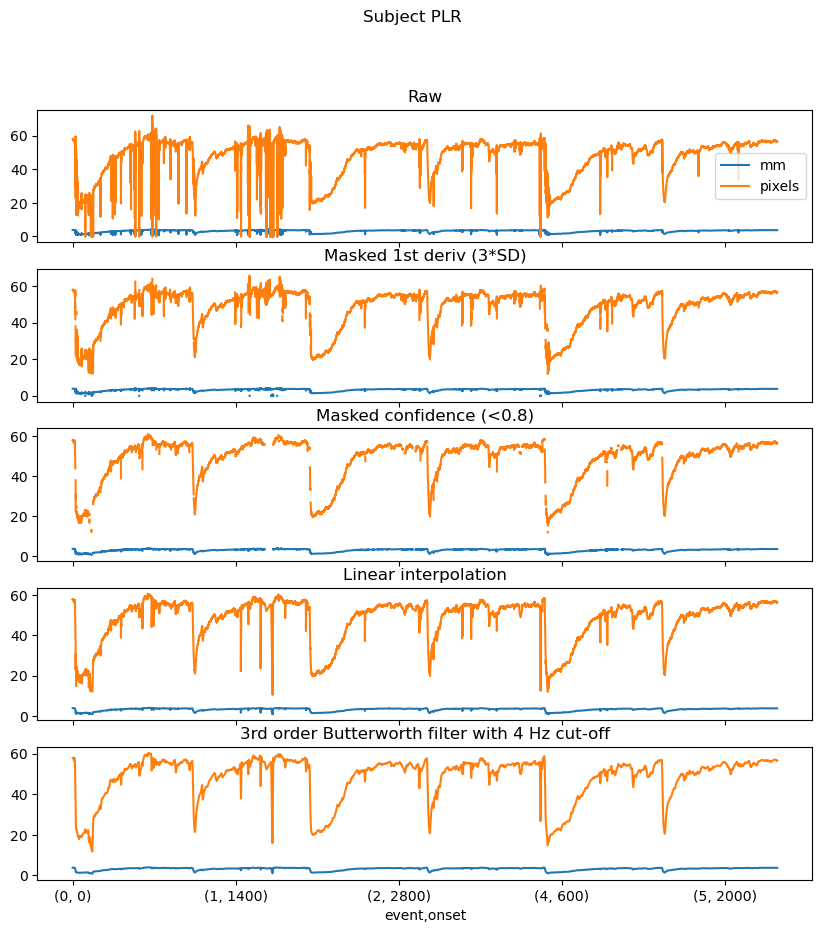

In [37]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [38]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.017848    1.000000   0  57.882680     3.776225        47   
      1      605241.035320    0.993964   0  57.896742     3.777007        48   
      2      605241.047513    0.931176   0  57.910550     3.777776        49   
      3      605241.069993    0.992103   0  57.923633     3.778503        50   
      4      605241.093087    1.000000   0  57.935516     3.779158        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605766.164323    0.917899   0  56.482114     3.684550     26468   
      3596   605766.183848    0.900309   0  56.500722     3.685646     26469   
      3597   605766.201882    0.939345   0  56.520179     3.686796     26470   
      3598   605766.225073    0.976928   0  56.539880     3.687964     26471   
      3599   605766.241500    0.937660   0  56.559183     3.689113     26472   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            1.065473     0.995228             0  
      1            1.117061     1.040132             0  
      2            0.954794     0.901676             0  
      3            1.285302     1.242920             0  
      4            1.153688     1.102968             0  
...                     ...          ...           ...  
5     3595        -0.244037    -0.569830             0  
      3596        -0.312424    -0.637674             0  
      3597        -0.100223    -0.445737             0  
      3598        -0.139742    -0.471083             0  
      3599         0.200927    -0.126731             0  

[21600 rows x 9 columns]

In [39]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.017848    1.000000   0  57.875007     3.775710        47   
      1      605241.035320    0.993964   0  57.900739     3.777638        48   
      2      605241.047513    0.931176   0  57.821397     3.771575        49   
      3      605241.069993    0.992103   0  58.016946     3.783923        50   
      4      605241.093087    1.000000   0  57.936747     3.779006        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605766.164323    0.917899   0  56.337152     3.674341     26468   
      3596   605766.183848    0.900309   0  56.298712     3.671822     26469   
      3597   605766.201882    0.939345   0  56.407463     3.679638     26470   
      3598   605766.225073    0.976928   0  56.393102     3.678183     26471   
      3599   605766.241500    0.937660   0  56.588212     3.690731     26472   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            1.065473     0.995228  
      1            1.117061     1.040132  
      2            0.954794     0.901676  
      3            1.285302     1.242920  
      4            1.153688     1.102968  
...                     ...          ...  
5     3595        -0.244037    -0.569830  
      3596        -0.312424    -0.637674  
      3597        -0.100223    -0.445737  
      3598        -0.139742    -0.471083  
      3599         0.200927    -0.126731  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

In [40]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\1788001868.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.072404    0.924084   1  69.738705     3.713527        47   
      1      605241.095511    0.911486   1  69.698938     3.711388        48   
      2      605241.120914    0.968885   1  69.671695     3.709917        49   
      3      605241.141229    0.914177   1  69.658772     3.709384        50   
      4      605241.165388    0.938254   1  69.711207     3.712341        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605759.835097    0.873960   1  68.499258     3.606559     26468   
      3596   605759.856330    0.883020   1  68.671178     3.615751     26469   
      3597   605759.876826    0.916439   1  68.894022     3.628187     26470   
      3598   605759.900057    0.867954   1  68.852245     3.624702     26471   
      3599   605759.919390    0.911606   1  68.638365     3.613718     26472   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.710218     0.762276  
      1            0.652193     0.704819  
      2            0.612297     0.665456  
      3            0.597852     0.646785  
      4            0.678053     0.722546  
...                     ...          ...  
5     3595        70.308401    71.864545  
      3596        70.742458    72.295891  
      3597        71.329678    72.855007  
      3598        71.165129    72.750190  
      3599        70.646429    72.213563  

[21600 rows x 8 columns]

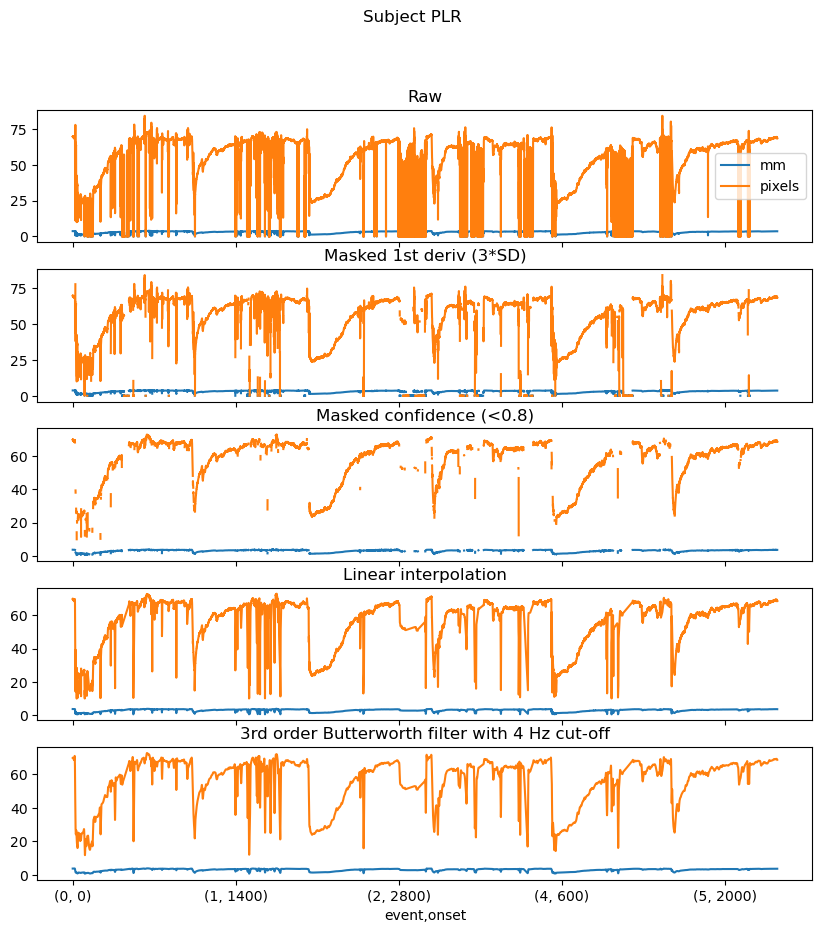

In [41]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [42]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.072404    0.924084   1  69.745430     3.713815        47   
      1      605241.095511    0.911486   1  69.733534     3.713349        48   
      2      605241.120914    0.968885   1  69.720999     3.712853        49   
      3      605241.141229    0.914177   1  69.707597     3.712315        50   
      4      605241.165388    0.938254   1  69.693125     3.711723        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605759.835097    0.873960   1  68.775944     3.621198     26468   
      3596   605759.856330    0.883020   1  68.741106     3.619316     26469   
      3597   605759.876826    0.916439   1  68.708582     3.617556     26470   
      3598   605759.900057    0.867954   1  68.678744     3.615939     26471   
      3599   605759.919390    0.911606   1  68.651891     3.614481     26472   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            0.710218     0.762276             0  
      1            0.652193     0.704819             0  
      2            0.612297     0.665456             0  
      3            0.597852     0.646785             0  
      4            0.678053     0.722546             0  
...                     ...          ...           ...  
5     3595        70.308401    71.864545             0  
      3596        70.742458    72.295891             0  
      3597        71.329678    72.855007             0  
      3598        71.165129    72.750190             0  
      3599        70.646429    72.213563             0  

[21600 rows x 9 columns]

In [43]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      605241.072404    0.924084   1  69.738705     3.713527        47   
      1      605241.095511    0.911486   1  69.698938     3.711388        48   
      2      605241.120914    0.968885   1  69.671695     3.709917        49   
      3      605241.141229    0.914177   1  69.658772     3.709384        50   
      4      605241.165388    0.938254   1  69.711207     3.712341        51   
...                    ...         ...  ..        ...          ...       ...   
5     3595   605759.835097    0.873960   1  68.499258     3.606559     26468   
      3596   605759.856330    0.883020   1  68.671178     3.615751     26469   
      3597   605759.876826    0.916439   1  68.894022     3.628187     26470   
      3598   605759.900057    0.867954   1  68.852245     3.624702     26471   
      3599   605759.919390    0.911606   1  68.638365     3.613718     26472   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.710218     0.762276  
      1            0.652193     0.704819  
      2            0.612297     0.665456  
      3            0.597852     0.646785  
      4            0.678053     0.722546  
...                     ...          ...  
5     3595        70.308401    71.864545  
      3596        70.742458    72.295891  
      3597        71.329678    72.855007  
      3598        71.165129    72.750190  
      3599        70.646429    72.213563  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [44]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [45]:
df_eye0["colour"] = ""

In [46]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [47]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [48]:
df_eye1["colour"] = ""

In [49]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_27052\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 0')

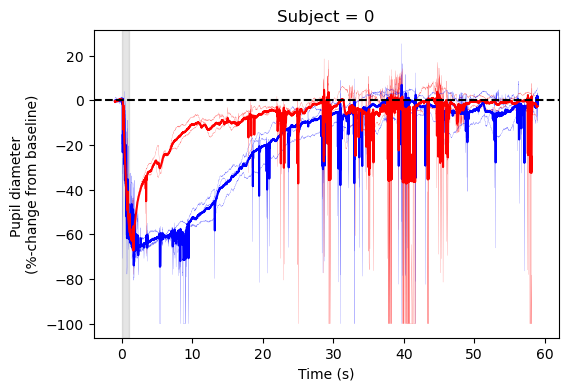

In [50]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye0['id'][0][0]))

In [52]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-789_ses-01_dat-20230728' + '-eye0.png')

In [53]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   605241.017848    1.000000   0  57.875007     3.775710   
      -0.983333   605241.035320    0.993964   0  57.900739     3.777638   
      -0.966667   605241.047513    0.931176   0  57.821397     3.771575   
      -0.950000   605241.069993    0.992103   0  58.016946     3.783923   
      -0.933333   605241.093087    1.000000   0  57.936747     3.779006   
...                         ...         ...  ..        ...          ...   
5      58.916667  605766.164323    0.917899   0  56.337152     3.674341   
       58.933333  605766.183848    0.900309   0  56.298712     3.671822   
       58.950000  605766.201882    0.939345   0  56.407463     3.679638   
       58.966667  605766.225073    0.976928   0  56.393102     3.678183   
       58.983333  605766.241500    0.937660   0  56.588212     3.690731   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         47        1.065473     0.995228   blue  
      -0.983333         48        1.117061     1.040132   blue  
      -0.966667         49        0.954794     0.901676   blue  
      -0.950000         50        1.285302     1.242920   blue  
      -0.933333         51        1.153688     1.102968   blue  
...                    ...             ...          ...    ...  
5      58.916667     26468       -0.244037    -0.569830    red  
       58.933333     26469       -0.312424    -0.637674    red  
       58.950000     26470       -0.100223    -0.445737    red  
       58.966667     26471       -0.139742    -0.471083    red  
       58.983333     26472        0.200927    -0.126731    red  

[21600 rows x 9 columns]

In [54]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

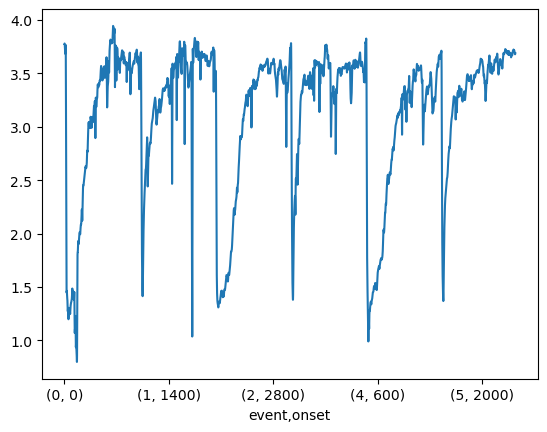

In [55]:
samples_eye0["diameter_3d"].plot()

In [56]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [57]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   605241.072404    0.924084   1  69.738705     3.713527   
      -0.983333   605241.095511    0.911486   1  69.698938     3.711388   
      -0.966667   605241.120914    0.968885   1  69.671695     3.709917   
      -0.950000   605241.141229    0.914177   1  69.658772     3.709384   
      -0.933333   605241.165388    0.938254   1  69.711207     3.712341   
...                         ...         ...  ..        ...          ...   
5      58.916667  605759.835097    0.873960   1  68.499258     3.606559   
       58.933333  605759.856330    0.883020   1  68.671178     3.615751   
       58.950000  605759.876826    0.916439   1  68.894022     3.628187   
       58.966667  605759.900057    0.867954   1  68.852245     3.624702   
       58.983333  605759.919390    0.911606   1  68.638365     3.613718   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         47        0.710218     0.762276   blue  
      -0.983333         48        0.652193     0.704819   blue  
      -0.966667         49        0.612297     0.665456   blue  
      -0.950000         50        0.597852     0.646785   blue  
      -0.933333         51        0.678053     0.722546   blue  
...                    ...             ...          ...    ...  
5      58.916667     26468       70.308401    71.864545    red  
       58.933333     26469       70.742458    72.295891    red  
       58.950000     26470       71.329678    72.855007    red  
       58.966667     26471       71.165129    72.750190    red  
       58.983333     26472       70.646429    72.213563    red  

[21600 rows x 9 columns]

Text(0.5, 1.0, 'Subject = 1')

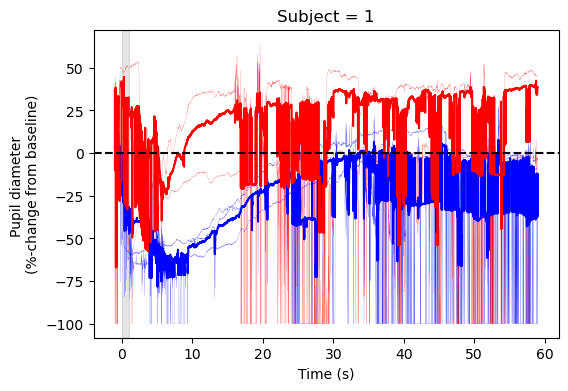

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye1['id'][0][0]))

In [60]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-789_ses-01_dat-20230728' + '-eye1.png')

In [61]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   605241.072404    0.924084   1  69.738705     3.713527   
      -0.983333   605241.095511    0.911486   1  69.698938     3.711388   
      -0.966667   605241.120914    0.968885   1  69.671695     3.709917   
      -0.950000   605241.141229    0.914177   1  69.658772     3.709384   
      -0.933333   605241.165388    0.938254   1  69.711207     3.712341   
...                         ...         ...  ..        ...          ...   
5      58.916667  605759.835097    0.873960   1  68.499258     3.606559   
       58.933333  605759.856330    0.883020   1  68.671178     3.615751   
       58.950000  605759.876826    0.916439   1  68.894022     3.628187   
       58.966667  605759.900057    0.867954   1  68.852245     3.624702   
       58.983333  605759.919390    0.911606   1  68.638365     3.613718   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         47        0.710218     0.762276   blue  
      -0.983333         48        0.652193     0.704819   blue  
      -0.966667         49        0.612297     0.665456   blue  
      -0.950000         50        0.597852     0.646785   blue  
      -0.933333         51        0.678053     0.722546   blue  
...                    ...             ...          ...    ...  
5      58.916667     26468       70.308401    71.864545    red  
       58.933333     26469       70.742458    72.295891    red  
       58.950000     26470       71.329678    72.855007    red  
       58.966667     26471       71.165129    72.750190    red  
       58.983333     26472       70.646429    72.213563    red  

[21600 rows x 9 columns]

In [62]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

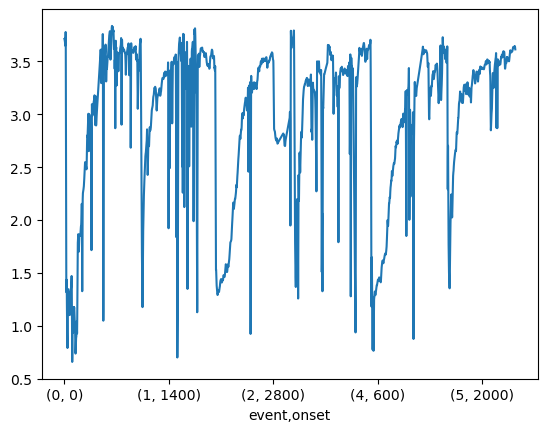

In [63]:
samples_eye1["diameter_3d"].plot()

In [64]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [65]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

     colour  onset  event      timestamp  confidence   id   diameter  \
480    blue    7.0    2.0  605434.008199    0.824391  0.0  22.710379   
4080    red    7.0    3.0  605524.823205    1.000000  0.0  44.689266   

      diameter_3d  orig_idx  diameter_3d_pc  diameter_pc  
480      1.495791    9489.0      -59.104741   -59.581437  
4080     2.924450   14073.0      -20.772934   -20.862444  
     colour  onset  event      timestamp  confidence   id   diameter  \
480    blue    7.0    2.0  605433.271998    0.802309  1.0  24.525292   
4080    red    7.0    3.0  605522.281179    1.000000  1.0  44.935721   

      diameter_3d  orig_idx  diameter_3d_pc  diameter_pc  
480      1.314314    9489.0      -61.469315   -61.883273  
4080     2.387617   14073.0      -11.466668   -11.934882  


In [66]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

PIPR (Absolute Difference), Eye 0:  1.4286596361935373
PIPR (Percent Change), Eye 0:  38.33180652169494


In [67]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)

PIPR (Absolute Difference), Eye 1:  1.0733030806095436
PIPR (Percent Change), Eye 1:  50.00264686661685
